# WSI - Ćwiczenie 3
### Michał Sadlej
### Wojciech Sarwiński

### 1. Sieci Neuronowe

Celem ćwiczenia jest implementacja perceptronu wielowarstwowego i algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Do trenowania sieci wykorzystujemy dane zbioru dt. cukrzycy [__Diabetes from AIM '94__](https://archive.ics.uci.edu/dataset/34/diabetes) dostępny na stronie repozytorium  [__UCI Machine Learning Repository__](https://archive.ics.uci.edu/).

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from typing import Optional, Callable, Literal
from itertools import pairwise
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_curve,
    auc,
)
from statistics import (
    stdev,
    mean,
)

### 2. Dane do klasyfikacji

Dane pacjentów z cukrzycą uzyskano z dwóch źródeł: automatycznego elektronicznego urządzenia rejestrującego i zapisów papierowych.  Automatyczne urządzenie miało wewnętrzny zegar do oznaczania czasu zdarzeń, podczas gdy zapisy papierowe zawierały tylko "logiczne sygnatury czasowe" tzn. stałe godziny zostały przypisane do śniadania (08:00), obiadu (12:00), kolacji (18:00) i snu (22:00).  W ten sposób zapisy papierowe mają z góry określone, jednorodne czasy zapisu, podczas gdy zapisy elektroniczne mają bardziej realistyczne sygnatury czasowe.

Pliki cukrzycy składają się z czterech pól na rekord:
- Data
- Godzina
- Kod
- Wartość glukozy w krwii

Pole __Kod__ jest odczytywane w następujący sposób:

$33$ = Regularna dawka insuliny

$34$ = dawka insuliny NPH

$35$ = Dawka insuliny UltraLente

$48$ = Nieokreślony wynik pomiaru stężenia glukozy we krwi

$57$ = Nieokreślony wynik pomiaru stężenia glukozy we krwi

$58$ = Pomiar stężenia glukozy we krwi przed śniadaniem

$59$ = Pomiar stężenia glukozy we krwi po śniadaniu

$60$ = Pomiar stężenia glukozy we krwi przed obiadem

$61$ = Pomiar stężenia glukozy we krwi po obiedzie

$62$ = Pomiar stężenia glukozy we krwi przed kolacją

$63$ = Pomiar stężenia glukozy we krwi po kolacji

$64$ = Pomiar stężenia glukozy we krwi przed przekąską

$65$ = Objawy hipoglikemii

$66$ = Typowy posiłek

$67$ = Posiłek większy niż zwykle

$68$ = Posiłek mniejszy niż zwykle

$69$ = Typowa aktywność fizyczna

$70$ = Aktywność fizyczna większa niż zwykle

$71$ = Mniejsza niż zwykle aktywność fizyczna

$72$ = Nieokreślone


In [2]:
def read_data() -> "pd.DataFrame":
    all_data = pd.DataFrame()
    for i in range(1, 71):
        # Generate the file name
        file_name = f"Diabetes-Data/data-{i:02d}"

        df = pd.read_csv(file_name, delimiter="\t", header=None)
        df.columns = ["Date", "Time", "Code", "Value"]

        # Append the data to the main DataFrame
        all_data = pd.concat([all_data, df], ignore_index=True)

    # Delete Date column
    all_data = all_data.drop(columns=["Date"])

    # Convert Time to minutes
    all_data["Time"] = all_data["Time"].apply(
        lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1]) if ":" in x else 0
    )

    all_data = all_data.loc[all_data["Time"] <= 1440]

    return all_data

In [3]:
raw_data = read_data()

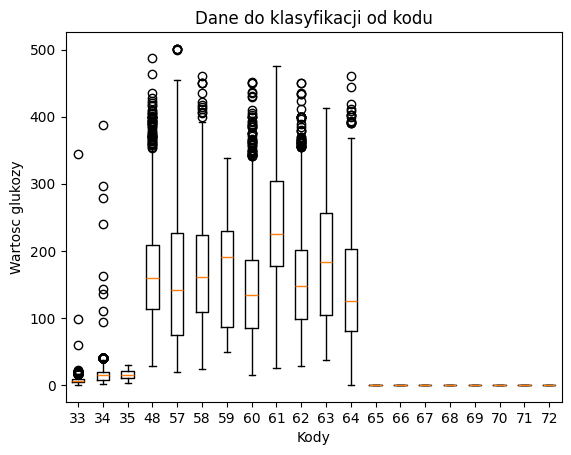

In [ ]:
def plot_raw_data_by_codes_box():
    grouped_values = raw_data.groupby("Code")['Value'].apply(list).reset_index()

    axes = plt.subplot()
    axes.boxplot(grouped_values["Value"], labels=grouped_values["Code"])
    axes.set_xlabel("Kody")
    axes.set_ylabel("Wartosc glukozy")
    axes.set_title("Dane do klasyfikacji od kodu")
    
plot_raw_data_by_codes_box()

Możemy zauważyć, że dane kodów z zakresu $[65, 72]$ przyjmują wartości równe 0, co oznacza, że mogą stanowić problem w celu ich klasyfikacji. Tak samo wartości z zakresu $[33, 35]$ przyjmują dane z podobnego zakresu.

Możemy też zauważyć, że, zgodnie z naszą intuicją, dane wartości glukozy we krwi z kodem $(58, 60, 62)$, tzn. przed posiłkiem, są niższe niż wartości z kodem $(59, 61, 63)$ po posiłku.

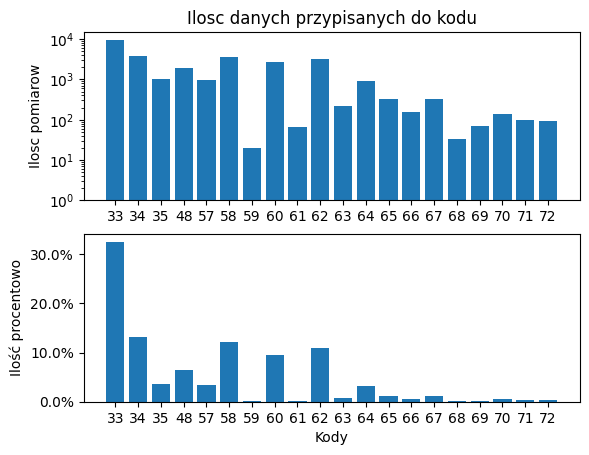

In [39]:
def plot_raw_data_by_codes_length():
    grouped_values = raw_data.groupby('Code')['Value'].apply(list).reset_index()
    grouped_values["Length"] = grouped_values["Value"].apply(len)
    grouped_values = grouped_values.drop(columns=["Value"])
    grouped_values["Code"] = grouped_values["Code"].astype(str)

    fig, (axes1, axes2) = plt.subplots(2, 1)
    axes1.bar(grouped_values["Code"], grouped_values["Length"])
    axes1.set_ylim(bottom=1, top=15000)
    axes1.set_yscale("log")
    axes1.set_ylabel("Ilosc pomiarow")
    axes1.set_title("Ilosc danych przypisanych do kodu")

    axes2.bar(grouped_values["Code"], grouped_values["Length"] / grouped_values["Length"].sum() * 100)
    axes2.yaxis.set_major_formatter(ticker.PercentFormatter())
    axes2.set_ylabel("Ilość procentowo")
    axes2.set_xlabel("Kody")


plot_raw_data_by_codes_length()

Zauważamy, że znaczącą ilość pomiarów stanowią dane z kodem z zakresu $[33, 35]$, tzn. po przyjęciu dawki insuliny, które stanowią około $45\%$ wszystkich pomiarów. Na drugim miejscu stanowią pomiary przed posiłkiem, które łącznie stanowią około $35\%$ wszyskich pomiarów. Na trzecim miejscu znajdują się dane z kodem  $(48, 57)$, tzn. "Nieokreślony wynik pomiaru stężenia glukozy w krwii", które stanowią około $10\%$ wszystkich pomiarów.

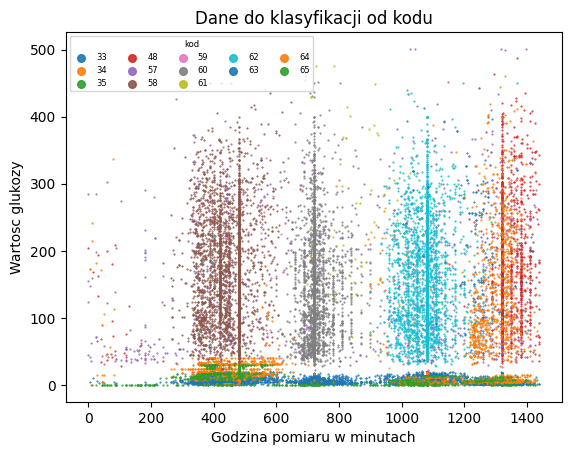

In [44]:
def plot_raw_data_by_time_box():

    grouped_values = raw_data.loc[raw_data["Code"] < 66]
    grouped_values = grouped_values.groupby("Code")
    axes = plt.subplot()

    for code, group in grouped_values:
        axes.scatter(group["Time"], group["Value"], s=0.3, alpha=0.9, label=code)
    
    axes.set_xlabel("Godzina pomiaru w minutach")
    axes.set_ylabel("Wartosc glukozy")
    axes.set_title("Dane do klasyfikacji od kodu")
    lgnd = axes.legend(title="kod", ncol= 5, loc="best", prop={'size' : 6})
    for handles in lgnd.legend_handles:
        handles._sizes = [30]
    lgnd.get_title().set_fontsize('6')

plot_raw_data_by_time_box()

Na wykresie widać wyraźnie cztery skupiska wyników:

- rano w zakresie godzin od 6:00 do 9:00 wyniki pomiarów glukozy przed śniadaniem _(kod 58)_

- w południu od 12:00 do 13:00 wyniki pomiarów glukozy przed obiadem _(kod 60)_

- po południu od 17:00 do 19:00 wyniki pomiarów glukozy przed kolacją _(kod 62)_

- wieczorem od 20:00 do 23:59 wyniki pomiarów glukozy przed przekąską _(kod 64)_ lub nieokreślonym wydarzeniem _(kod 48)_

Dodatkowo na dole widać pasmo niskich wartości pomiarów glukozy po dawce insuliny _(kod od 33 do 35)_.

### 3. Normalizacja danych

Po analizie danych podjeliśmy decyzję, żeby zgrupować dane, gdzie wartości pomiaru glukozy przyjmują zawsze 0 z kodami z zakresu od $[65, 72]$, do jednej kategorii $72$: "Nieokreślone".

Następnie dane czasu i pomiaru stężenia glukozy zostały znormalizowane do wartości z zakresu $[0, 1]$, a kody otrzymały własny index i przypisane do kodowania $1$ z $n$.

In [93]:
def normalize_raw_data() -> tuple[np.ndarray, np.ndarray]:
    data = raw_data.copy(deep=True)
    data["Code"] = data["Code"].replace(range(65, 72), 72)
    unique_codes = sorted(data["Code"].unique())
    code_map = {code: i for i, code in enumerate(unique_codes)}
    data["Time"] = data["Time"] / (24 * 60)
    data["Value"] = data["Value"] / data["Value"].max()
    data["Code"] = data["Code"].map(code_map)
    data = data.sample(frac=1.0).reset_index(drop=True)

    one_hot_code = np.eye(max(code_map.values()) + 1)[data["Code"].to_numpy(dtype=np.int32)]

    return data[["Time", "Value"]].to_numpy(dtype=np.float32)[:, np.newaxis, :], one_hot_code

normalized_data_input, normalized_data_output = normalize_raw_data()

g_input_count = normalized_data_input.shape[-1]
g_output_count = normalized_data_output.shape[-1]

Następnie dane dzielimy na dwa zbiory: zbiór treningowy i zbiór testowy.

In [94]:
g_separation = int(normalized_data_input.shape[0] * 0.8)
g_learning_x = normalized_data_input[:g_separation]
g_learning_y = normalized_data_output[:g_separation]
g_testing_x = normalized_data_input[g_separation:]
g_testing_y = normalized_data_output[g_separation:]

### 4. Perceptronu wielowarstwowy

In [86]:
class NeuronLayer:
    """
    Class NeuronLayer. Represents a single layer of a neural network.

    Attributes:
    ----------
    input_size : int
        Size of the input.
    output_size : int
        Size of the output.
    weights : numpy.ndarray
        Weights of the layer.
    bias : numpy.ndarray
        Bias of the layer.
    input : numpy.ndarray
        Input of the layer.
    output : numpy.ndarray
        Output of the layer.
    """

    input_size: int
    output_size: int

    weights: np.ndarray
    bias: np.ndarray

    input: np.ndarray
    output: np.ndarray

    def __init__(self, input_size: int, output_size: int) -> None:
        self.input_size = input_size
        self.output_size = output_size

        self.weights = 0.05 * np.random.randn(input_size, output_size) + 0.5
        self.bias = 0.05 * np.random.randn(1, output_size) + 0.5

        self.input = None
        self.output = None

    def forwardPropagation(self, input: np.ndarray) -> np.ndarray:
        """
        Performs forward propagation of the layer.

        Parameters:
        ----------
        input : numpy.ndarray
            Input of the layer.

        Returns:
        -------
        numpy.ndarray
            Output of the layer.
        """

        self.input = input
        self.output = self._sigmoid(np.dot(self.input, self.weights) + self.bias)

        return self.output

    def backwardPropagation(self, dE_dY: np.ndarray, alfa: float) -> np.ndarray:
        """
        Performs backward propagation of the layer.

        Parameters:
        ----------
        dE_dY : numpy.ndarray
            Gradient of the error with respect to the output.
        alfa : float
            Learning rate.

        Returns:
        -------
        numpy.ndarray
            Gradient of the error with respect to the input.
        """

        dE_dX = np.dot(dE_dY, self.weights.T)
        dE_dW = np.dot(self.input.T, dE_dY)
        self.weights -= alfa * dE_dW
        self.bias -= alfa * dE_dY

        return self._sigmoidDerivative(self.input) * dE_dX

    @staticmethod
    def _sigmoid(x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def _sigmoidDerivative(x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x)) * (1 - 1 / (1 + np.exp(-x)))
    
    def __repr__(self) -> str:
        return f"NeuronLayer({self.input_size}, {self.output_size})"


class NeuralNetwork:
    """
    Class NeuralNetwork. Represents a neural network.

    Attributes:
    ----------
    layers : list[NeuronLayer]
        List of layers in the neural network.
    errors : np.ndarray
        Training errors.
    """

    layers: list[NeuronLayer]
    errors: np.ndarray

    def __init__(self, input: int, output: int, hidden_layers: Optional[tuple[int, ...]] = ()) -> None:

        layers_init = []
        if hidden_layers:
            layers_init.append(NeuronLayer(input, hidden_layers[0]))
            for a, b in pairwise(hidden_layers):
                layers_init.append(NeuronLayer(a, b))
            layers_init.append(NeuronLayer(hidden_layers[-1], output))
        else:
            layers_init.append(NeuronLayer(input, output))
        
        self.layers = layers_init
        self.errors = None

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts the output for the given input data.

        Parameters:
        ----------
        X : numpy.ndarray
            Input data.

        Returns:
        -------
        np.ndarray
            Predicted outputs.
        """

        samples = X.shape[0]
        result = np.zeros((samples, self.layers[-1].output_size))

        for i in range(samples):
            output = X[i]

            for layer in self.layers:
                output = layer.forwardPropagation(output)

            result[i] = output

        return result

    def train(
        self, X: np.ndarray, y: np.ndarray, n_epochs: int = 100, alfa=0.1
    ) -> None:
        """
        Trains the neural network.

        Parameters:
        ----------
        X : numpy.ndarray
            Input data.
        y : numpy.ndarray
            Output data.
        n_epochs : int
            Number of epochs.
        alfa : float
            Learning rate.

        Returns:
        -------
        None
        """

        n_samples = X.shape[0]
        self.errors = np.zeros(n_epochs)

        for epoch in range(n_epochs):
            cost = 0

            for i in range(n_samples):
                output = X[i]

                for layer in self.layers:
                    output = layer.forwardPropagation(output)

                cost += self._cost(y[i], output)
                dE_dY = self._costDerivative(y[i], output)

                for layer in reversed(self.layers):
                    dE_dY = layer.backwardPropagation(dE_dY, alfa)

            self.errors[epoch] = cost / n_samples

    @staticmethod
    def _cost(y: np.ndarray, prediction: np.ndarray) -> float:
        return np.mean((y - prediction) ** 2)

    def _costDerivative(self, y: np.ndarray, prediction: np.ndarray) -> np.ndarray:
        return 2 * (prediction - y) / y.size
    
    def __repr__(self) -> str:
        return f"NeuralNetwork({str(self.layers)})"

In [98]:
nn = NeuralNetwork(g_input_count, g_output_count, (6,))
nn.train(g_learning_x, g_learning_y, 15, 0.2)

In [107]:
def precision_recall_score(neural_network :NeuralNetwork) -> tuple[float, float]:
    pred_y = neural_network.predict(g_testing_x)
    pred_y = np.argmax(pred_y, axis=1)
    test_y = np.argmax(g_testing_y, axis=1)

    precision = precision_score(test_y, pred_y, average='micro')
    recall = recall_score(test_y, pred_y, average='micro')

    return precision, recall

print("Precision = {:.4f}\nRecall = {:.4f}".format(*precision_recall_score(nn)))

Precision = 0.6799
Recall = 0.6799


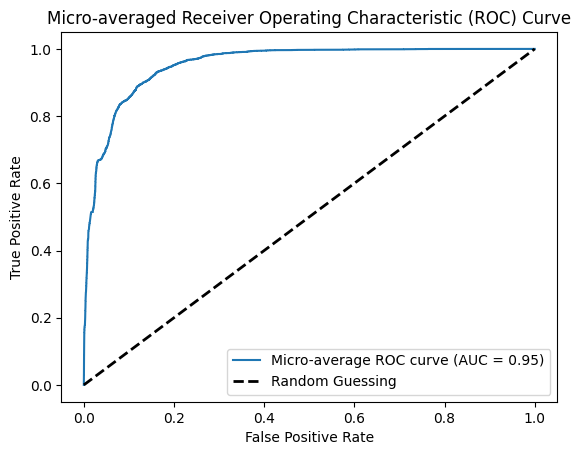

In [119]:
def plot_roc(neural_network :NeuralNetwork):
    pred_y = neural_network.predict(g_testing_x)
    fpr, tpr, _ = roc_curve(g_testing_y.ravel(), pred_y.ravel())
    roc_auc = auc(fpr, tpr)

    axes = plt.subplot()
    axes.plot(fpr, tpr, label=f'Micro-average ROC curve (AUC = {roc_auc:.2f})')
    axes.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guessing')
    axes.set_ylabel('True Positive Rate')
    axes.set_title('Micro-averaged Receiver Operating Characteristic (ROC) Curve')
    axes.legend()
    axes.set_xlabel('False Positive Rate')

    
plot_roc(nn)

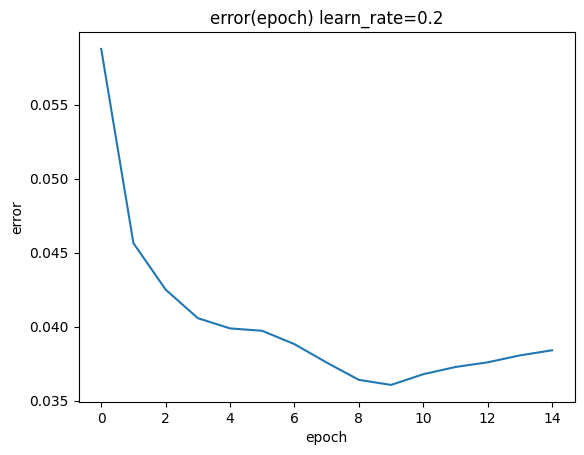

In [122]:
def plot_error_over_learning(neural_network :NeuralNetwork):
    axes = plt.subplot()
    axes.plot(neural_network.errors)
    axes.set_title(f"error(epoch) learn_rate={0.2}")
    axes.set_xlabel("epoch")
    axes.set_ylabel("error")

plot_error_over_learning(nn)

### 5. Wpływy parametru uczenia $\alpha$ na działanie algorytmu

W tej części ćwiczenia sprawdzimy wpływ parametru uczenia $\alpha$ eposodów nauczania na efektywność algorytmu.


In [136]:
def train_learning_rate_range():
    learning_rates = np.linspace(0.1, 0.35, 5).tolist()

    training_results = {key: [] for key in learning_rates}

    for learning_rate in learning_rates:
        for _ in range(3):
            nn = NeuralNetwork(g_input_count, g_output_count, (6,))
            nn.train(g_learning_x, g_learning_y, 10, learning_rate)
            training_results[learning_rate].append(nn)
    
    return training_results


g_trained_nns = train_learning_rate_range()

KeyboardInterrupt: 

C:\Users\sarwi\AppData\Local\Temp\ipykernel_4992\4211180703.py:85: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\sarwi\AppData\Local\Temp\ipykernel_4992\4211180703.py:85: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


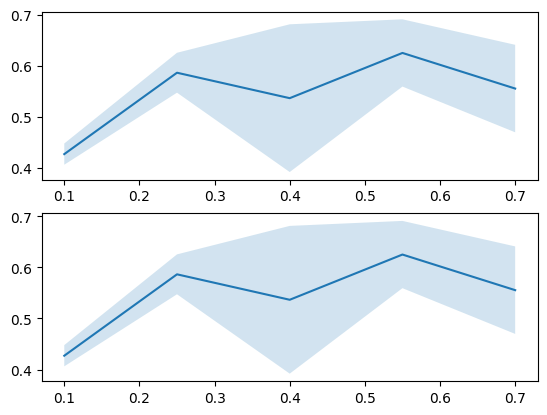

In [135]:
def plot_precision_recall():
    precisions_per_lr = {}
    recall_per_lr = {}

    for learning_rate, network_list in g_trained_nns.items():
        precisions = []
        recalls = []
        for network in network_list:
            precision, recall = precision_recall_score(network)
            precisions.append(precision)
            recalls.append(recall)
        precisions_per_lr[learning_rate] = precisions
        recall_per_lr[learning_rate] = recalls
    
    precisions = [mean(precision) for precision in precisions_per_lr.values()]
    precisions_dev = [stdev(precision) for precision in precisions_per_lr.values()]
    recalls = [mean(recall) for recall in recall_per_lr.values()]
    recalls_dev = [stdev(recall) for recall in recall_per_lr.values()]
    learning_rates = list(precisions_per_lr.keys())

    fig, (axes1, axes2) = plt.subplots(2, 1)
    axes1.plot(learning_rates, precisions)
    axes1.fill_between(
        learning_rates,
        [precision - deviation for precision, deviation in zip(precisions, precisions_dev)],
        [precision + deviation for precision, deviation in zip(precisions, precisions_dev)],
        alpha=0.2
    )
    
    axes2.plot(learning_rates, recalls)
    axes2.fill_between(
        learning_rates,
        [recall - deviation for recall, deviation in zip(recalls, recalls_dev)],
        [recall + deviation for recall, deviation in zip(recalls, recalls_dev)],
        alpha=0.2
    )

plot_precision_recall()